This is the python code for User Car Dataset to predict car prices. 

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
from pandas import DataFrame, Series
import math
import warnings 
warnings.filterwarnings('ignore')

In [53]:
data = pd.read_csv('../content/sample_data/vehicles.csv')

In [54]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [55]:
print ('This is the size of the raw data: ',data.shape)

This is the size of the raw data:  (426880, 18)


In [56]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Initial check for Null value in the dataset

In [57]:
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Checking for pricing abnormality on the extreme end for car more than 20 yrs with pricing above 300,000. This would consider as a "collectible" catagory.

In [ ]:
((data['price']>200000)&(data['year']>2013)).value_counts()

False    426809
True         71
dtype: int64

Checking for pricing abnormality on the extreme end for car less than 20 yrs with pricing above 300,000. This would consider as "exotic" catagory.

In [ ]:
((data['price']>200000)&(data['year']<2013)).value_counts()

False    426827
True         53
dtype: int64

The data is sliced for cars after 2003 only. Assuming people don't buy use car older than 20 yrs. Anything older than 20 yrs would consider collectible which is valuated under difference set of rules.

In [58]:
data=data.drop(data[(data.year < 2003)].index)

Certain Data is dropped for invalid title, salvage condition, vehicle type such as as bus and truck. Also price and year that are null are dropped as well.

In [59]:
data=data.drop(data[(data.title_status == 'parts only') | (data.title_status == 'rebuilt')|(data.title_status == 'salvage')| (data.title_status == 'missing') | (data.title_status == 'lien')].index)
data=data.drop(data[(data.condition == 'salvage')].index)
data=data.drop(data[(data.type == 'bus')| (data.type == 'truck')].index)
data=data.drop(data[(data.price == 0)].index)
data=data.drop(data[(data.year == 0)].index)


In [60]:
data.loc[(data.cylinders=='4 cylinders') & (data.manufacturer == 'ferrari'), 'cylinders']='8 cylinders'
data.loc[(data.cylinders=='4 cylinders') & (data.manufacturer == 'porsche'), 'cylinders']='8 cylinders'
data.drop(data[(data.cylinders=='4 cylinders') & (data.manufacturer == 'ford')& (data.price > 100000)].index)



,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


**All cars over 300,000 in price and older than 2003**, this is consider as "Collectible" catagory which is dropped
**All cars over 300,000 in price and newer than 2003**, this is consider as "exotic" catagory which is dropped
The decision behind this is to avoid data extreme on both end of the sprectrum.

In [61]:
data=data.drop(data[(data.price > 200000)&(data.year < 2003)].index)
data=data.drop(data[(data.price > 200000)&(data.year > 2003)].index)

Manufacturer and Model data are dropped since vehicale type and size are provided. This way we can keep the dataset and avoid brand bias Since vehicle brand has direct impact on pricing.

In [62]:
data=data.drop(columns=['region','state','VIN','manufacturer','model','paint_color','title_status'])

Drop all rows with Null/NA/Empty value. There are catagorical data such as Type and Size can perform a lookup in the dataset to re-populate the empty field.  

In [63]:
data=data.dropna()

In [64]:
data.head()

,id,price,year,condition,cylinders,fuel,odometer,transmission,drive,size,type
55,7314560853,19900,2004.0,good,8 cylinders,diesel,88000.0,automatic,4wd,full-size,pickup
59,7313406529,14000,2012.0,excellent,6 cylinders,gas,95000.0,automatic,fwd,full-size,mini-van
86,7310644616,3000,2004.0,good,6 cylinders,gas,176144.0,automatic,fwd,mid-size,mini-van
110,7307730503,9500,2003.0,excellent,6 cylinders,gas,30376.0,automatic,fwd,mid-size,mini-van
119,7306407989,17500,2008.0,good,6 cylinders,gas,201300.0,manual,4wd,full-size,offroad


Check on updated dataset's dimensions

In [65]:
data.shape

(53441, 11)

Code all catagorical data column into numerical data column individually

In [66]:
coded=pd.get_dummies(data)

In [67]:
coded.head()

,id,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,cylinders_10 cylinders,...,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_van,type_wagon
55,7314560853,19900,2004.0,88000.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59,7313406529,14000,2012.0,95000.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
86,7310644616,3000,2004.0,176144.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
110,7307730503,9500,2003.0,30376.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
119,7306407989,17500,2008.0,201300.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Set Price of Car as Target in y . All features/inputs is set as X.

In [68]:
X=coded.drop(['price'],axis=1)
y=coded['price']


Split the data set into training and test portion into 70/30 portion.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Set a selector pipe using Linear Regresion with Sequntial Feature Selector. This Sequential Feature Selector adds forward selection to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [70]:
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])
selector_pipe

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression())),
                ('model', LinearRegression())])

Set Parameter Dictionary for up to 10 parameters and GridSearch for the fit and prediction



In [71]:
param_dict = {}
selector_grid = ''
selector_train_mse = ''
selector_test_mse = ''

param_dict = {'selector__n_features_to_select': [5,6,7,8,9,10]}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)

print("Error Table")
print('Mean Absolute Error      : ', mean_absolute_error(y_test, test_preds))
print('Mean Squared  Error      : ', mean_squared_error(y_test, test_preds))
print('Root Mean Squared Error  : ', np.sqrt(mean_squared_error(y_test, test_preds)))
print('R Squared Error          : ', r2_score(y_test, test_preds))


Error Table
Mean Absolute Error      :  4754.800646233637
Mean Squared  Error      :  60338081.91143701
Root Mean Squared Error  :  7767.759130626864
R Squared Error          :  0.5198709746109931


Set a pipe using Ridge Regresion with Polynomial Features and StandardScaler.

In [75]:
ridge_param_dict = ''
ridge_pipe = ''
ridge_grid = ''
ridge_train_mse = ''
ridge_test_mse = ''

ridge_param_dict = {'ridge__alpha': [0.001,0.01,0.1,1,10]}
ridge_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict,scoring='neg_mean_squared_error',cv=10)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",ridge_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",ridge_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",ridge_grid.best_params_)

print("\nError Table")
print('Mean Absolute Error      : ', mean_absolute_error(y_test, test_preds))
print('Mean Squared  Error      : ', mean_squared_error(y_test, test_preds))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, test_preds)))
print('R Squared Error          : ', r2_score(y_test, test_preds))



 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('polyfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.1))])

 The best score across ALL searched params:
 -1497512643.3293555

 The best parameters across ALL searched params:
 {'ridge__alpha': 0.1}

Error Table
Mean Absolute Error      :  4754.800646233637
Mean Squared  Error      :  60338081.91143701
Root Mean Squared  Error :  7767.759130626864
R Squared Error          :  0.5198709746109931


In [ ]:
res = permutation_importance(ridge_grid.best_estimator_, X, y)
sorted_idx = res.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), res.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

Set a pipeline with Lasso Regression using Polynomial Features and Standard 
Scaler

In [ ]:
lasso_param_dict = ''
lasso_pipe = ''
lasso_grid = ''
lasso_train_mse = ''
lasso_test_mse = ''

lasso_param_dict = {'lasso__alpha': np.arange(0, 10, 0.1)}
lasso_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 2, include_bias = False)),
                      ('scaler', StandardScaler()), 
                      ('lasso', Lasso())])
lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_dict,scoring='neg_mean_squared_error',cv=10)
lasso_grid.fit(X_train, y_train)
lasso_train_preds = lasso_grid.predict(X_train)
lasso_test_preds = lasso_grid.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",lasso_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",lasso_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",lasso_grid.best_params_)

print("Error Table")
print('Mean Absolute Error      : ', mean_absolute_error(y_test, test_preds))
print('Mean Squared  Error      : ', mean_squared_error(y_test, test_preds))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, test_preds)))
print('R Squared Error          : ', r2_score(y_test, test_preds))

Best value for lambda :  {'lasso__alpha': 10}
Best score for cost function:  -85589688.88320848
Error Table
Mean Absolute Error      :  6025.397484314429
Mean Squared  Error      :  99610510.18211131
Root Mean Squared  Error :  9980.506509296576
R Squared Error          :  0.5459114884600689


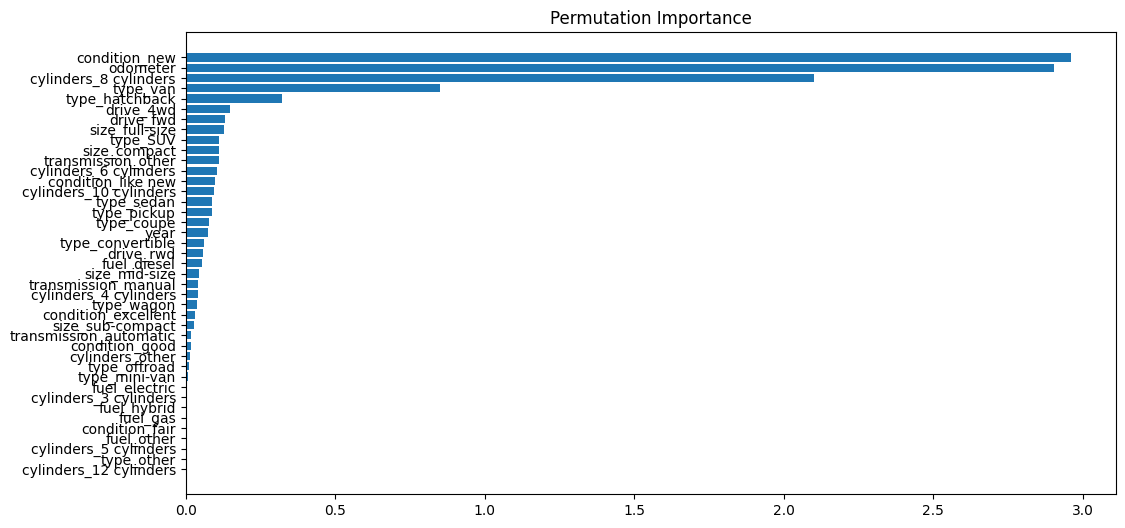

In [ ]:
res = permutation_importance(lasso_grid.best_estimator_, X, y)
sorted_idx = res.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), res.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

In [ ]:
best_estimator = ''
best_selector = ''
best_model = ''
feature_names = ''
coefs = ''

best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

NameError: ignored

In [ ]:

pipeline = make_pipeline(StandardScaler(), LogisticRegression())
# perform k-Fold cross-validation
kf = KFold(n_splits=11, shuffle=True, random_state=2)
# k-fold cross-validation conduction
cv_results = cross_val_score(pipeline, # Pipeline
                             X_train, # Feature matrix
                             y_train, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores
# View score for all 11 folds
cv_results

array([0.0919794 , 0.07658321, 0.08100147, 0.09351988, 0.08615611,
       0.08468336, 0.09720177, 0.08689249, 0.09499264, 0.0832106 ,
       0.10530191])

Accuracy on test data: 0.16


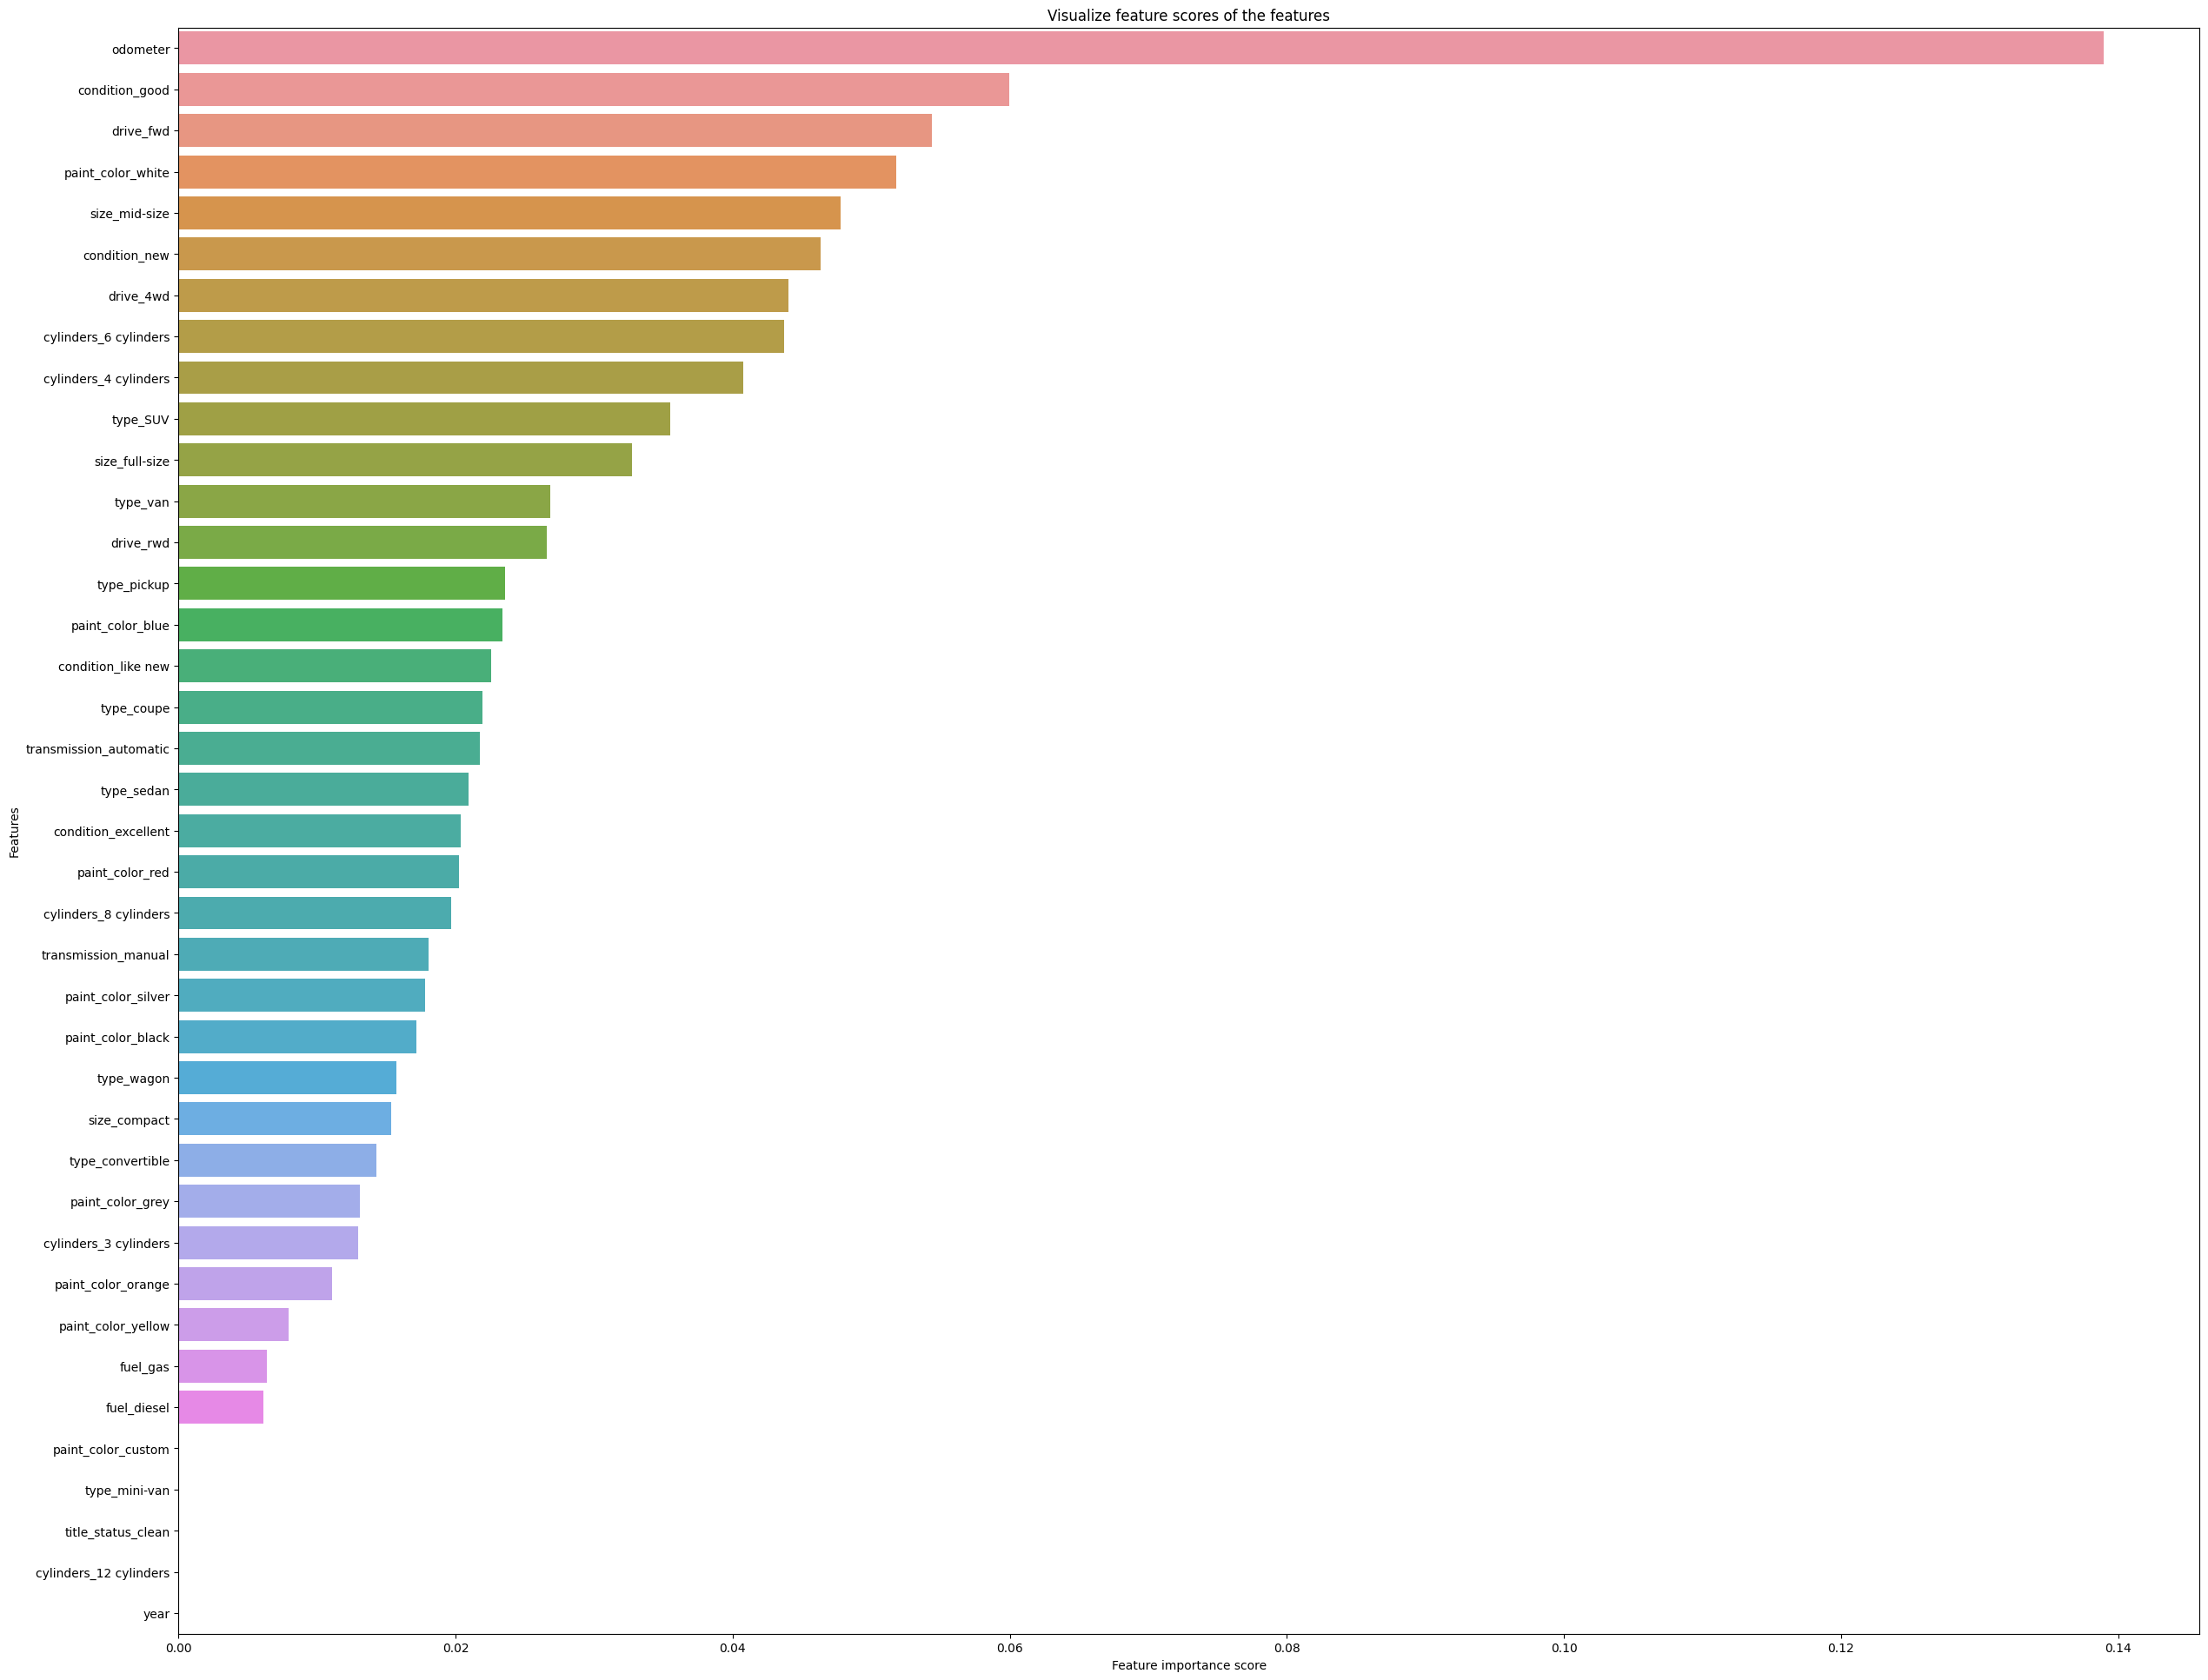

In [ ]:
model= RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(model.score(X_test, y_test)))

feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=data)
ax.set_title("Feature Importance")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))
scores = cross_val_score(pipeline, X=X_train, y=y_train, cv=5, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
 

Cross Validation accuracy scores: [0.55555556 0.44444444 0.55555556 0.375      0.5       ]
Cross Validation accuracy: 0.486 +/- 0.069


In [ ]:
data2=pd.read_csv('../content/sample_data/vehicles.csv')



In [ ]:
data2.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [ ]:
data2=data2.dropna()

In [ ]:
data2=data2.drop(data2[(data2.title_status == 'parts only') | (data2.title_status == 'rebuilt')|(data2.title_status == 'salvage')| (data2.title_status == 'missing') | (data2.title_status == 'lien')].index)
data2=data2.drop(data2[(data2.condition == 'salvage')].index)
data2=data2.drop(data2[(data2.type == 'bus')| (data2.type == 'truck')].index)
data2=data2.drop(data2[(data2.price == 0)].index)
data2=data2.drop(data2[(data2.year == 0)].index)

In [ ]:
data2.isnull().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

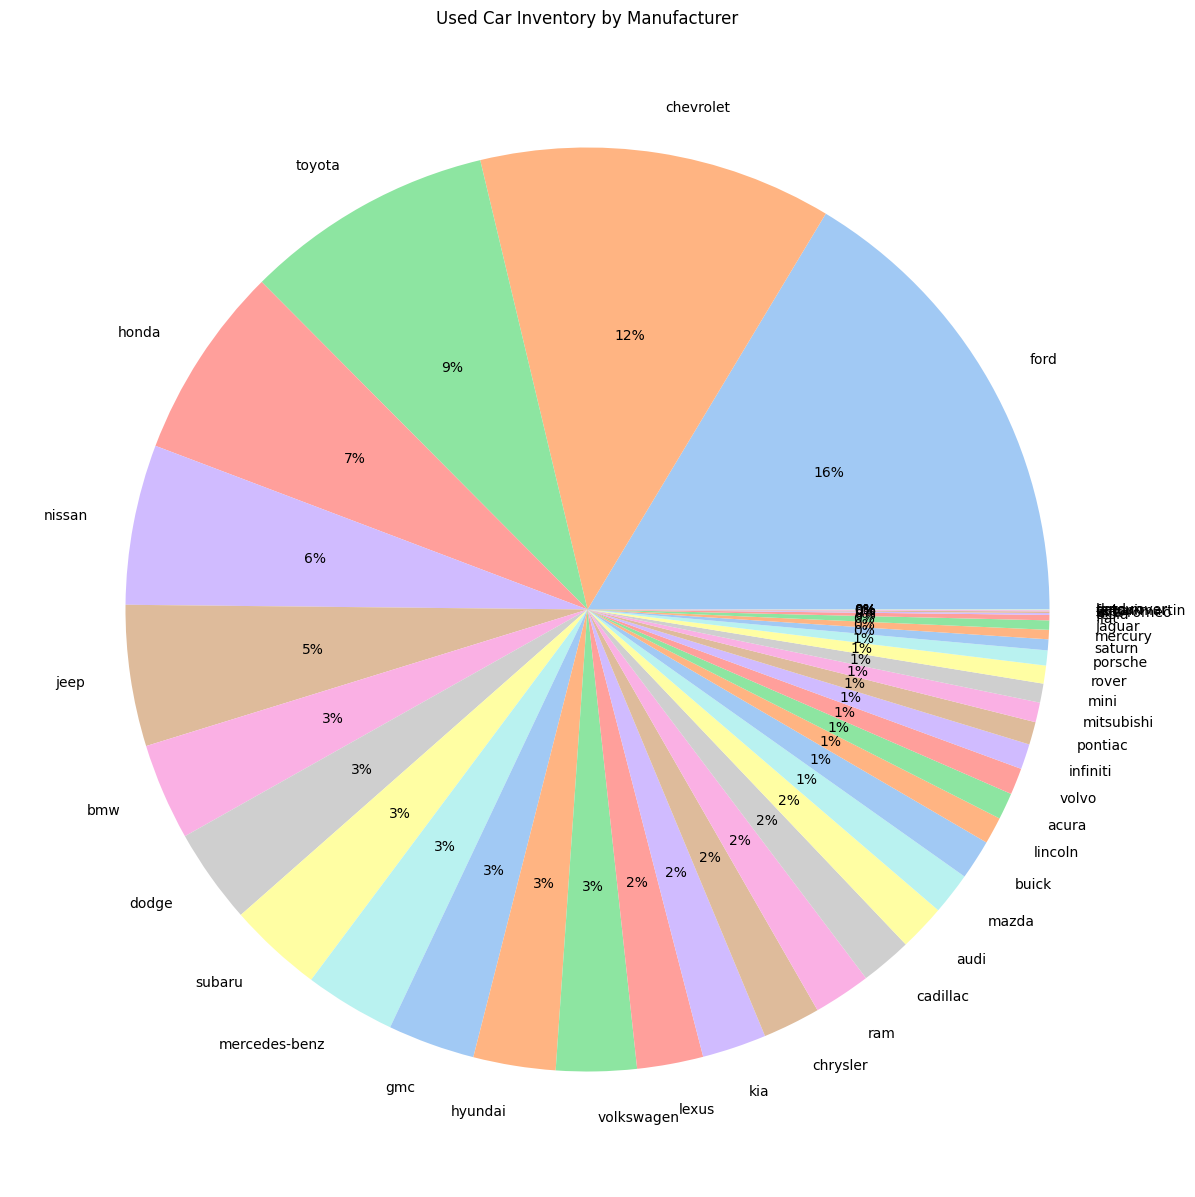

In [ ]:
plt.figure(figsize=(15, 15))
piel=data2['manufacturer'].value_counts().index.values
pied=data2['manufacturer'].value_counts().reset_index()['manufacturer']
colors = sns.color_palette('pastel')[0:15]
plt.pie(pied, labels = piel, colors=colors,autopct='%.0f%%')
plt.title('Used Car Inventory by Manufacturer')
plt.show()

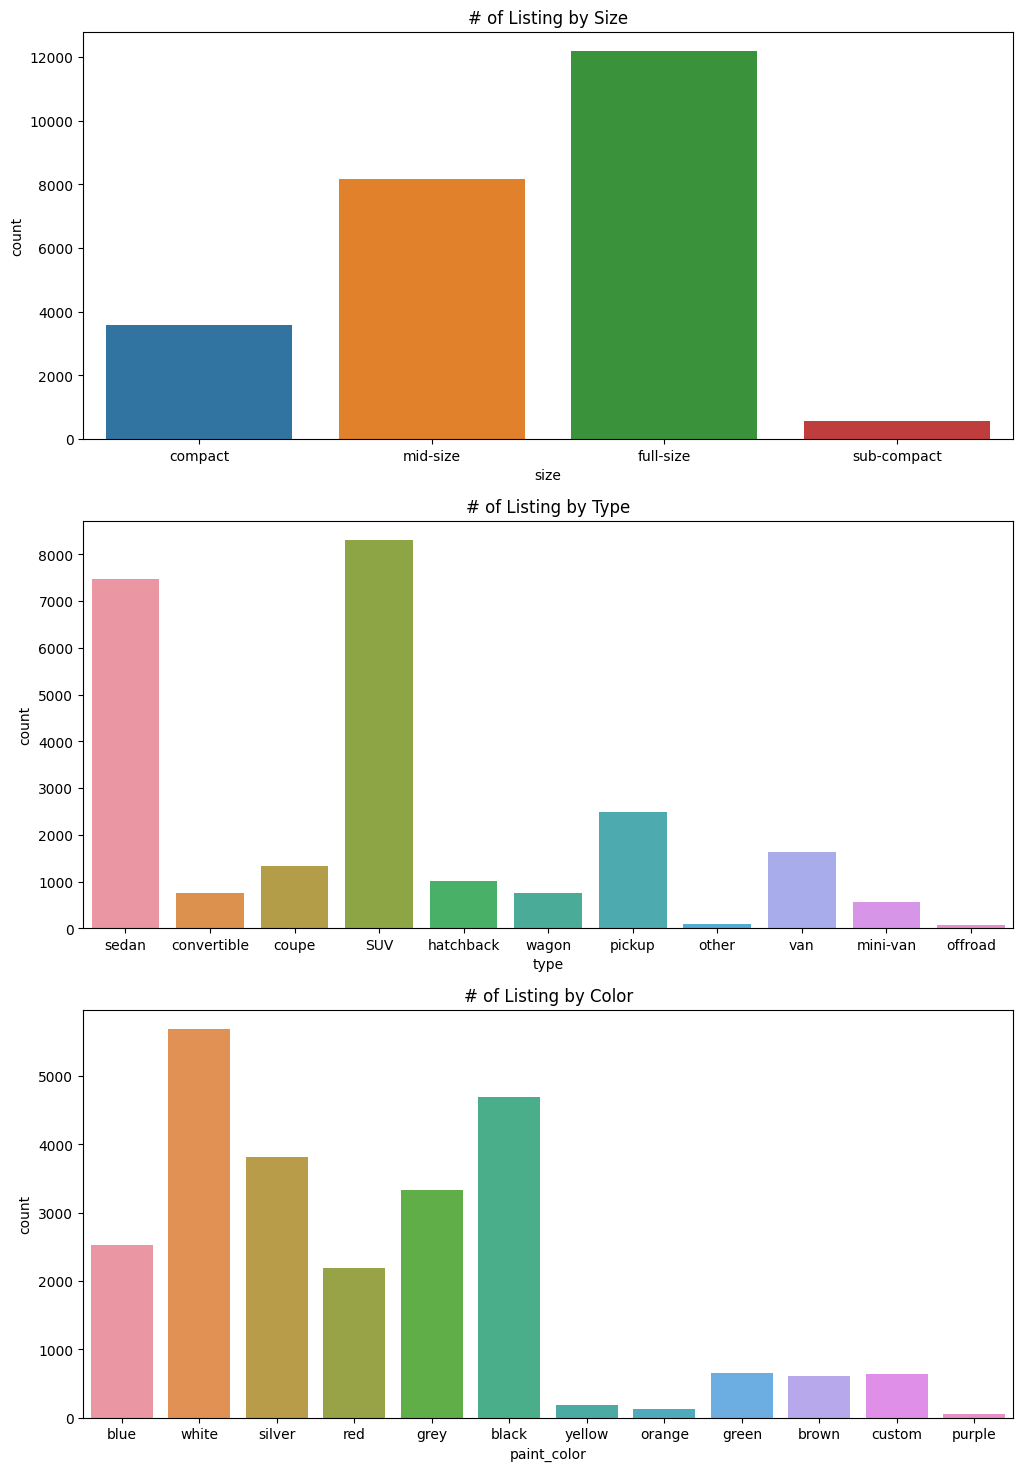

In [ ]:
fig,ax = plt.subplots(3, figsize=(12,18))
sns.countplot(data=data2,x='size', ax=ax[0])
sns.countplot(data=data2,x='type', ax=ax[1])
sns.countplot(data=data2, x='paint_color', ax=ax[2])
ax[0].set_title('# of Listing by Size')
ax[1].set_title("# of Listing by Type")
ax[2].set_title("# of Listing by Color")
fig.show()


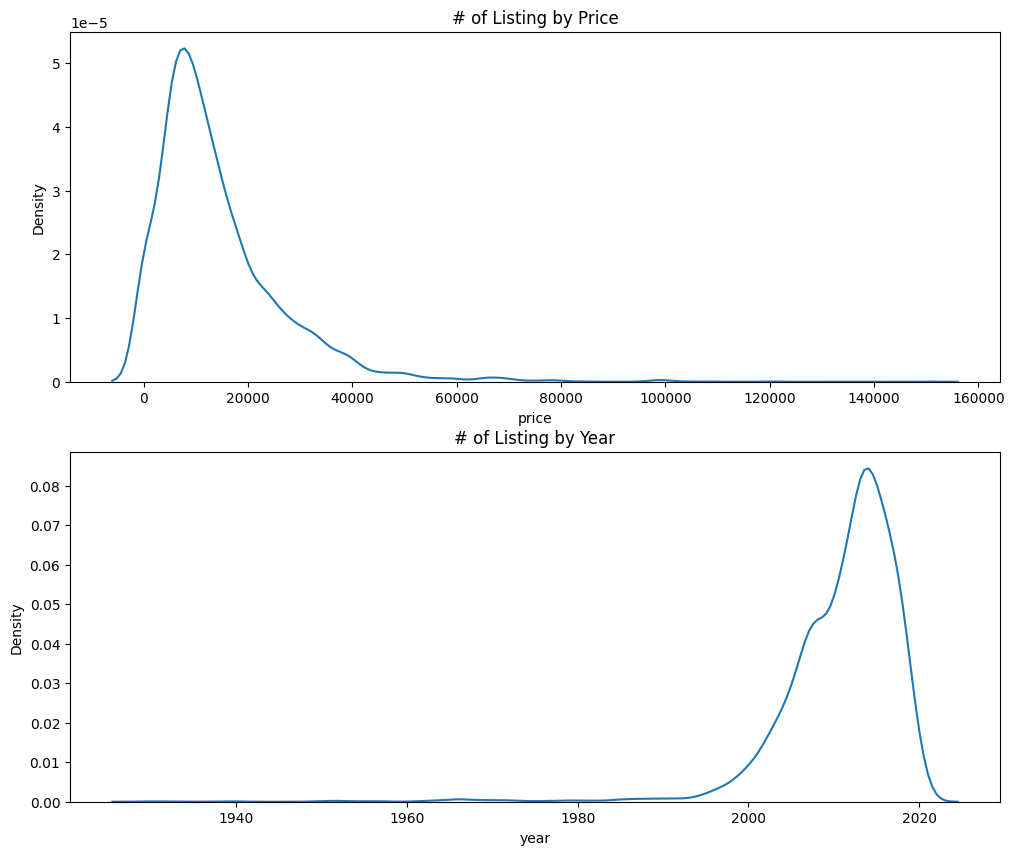

In [ ]:
fig1,ax = plt.subplots(2, figsize=(12,10))
sns.kdeplot(data=data2, x='price', ax=ax[0])
sns.kdeplot(data=data2, x='year', ax=ax[1])
ax[0].set_title('# of Listing by Price')
ax[1].set_title("# of Listing by Year")
fig1.show()

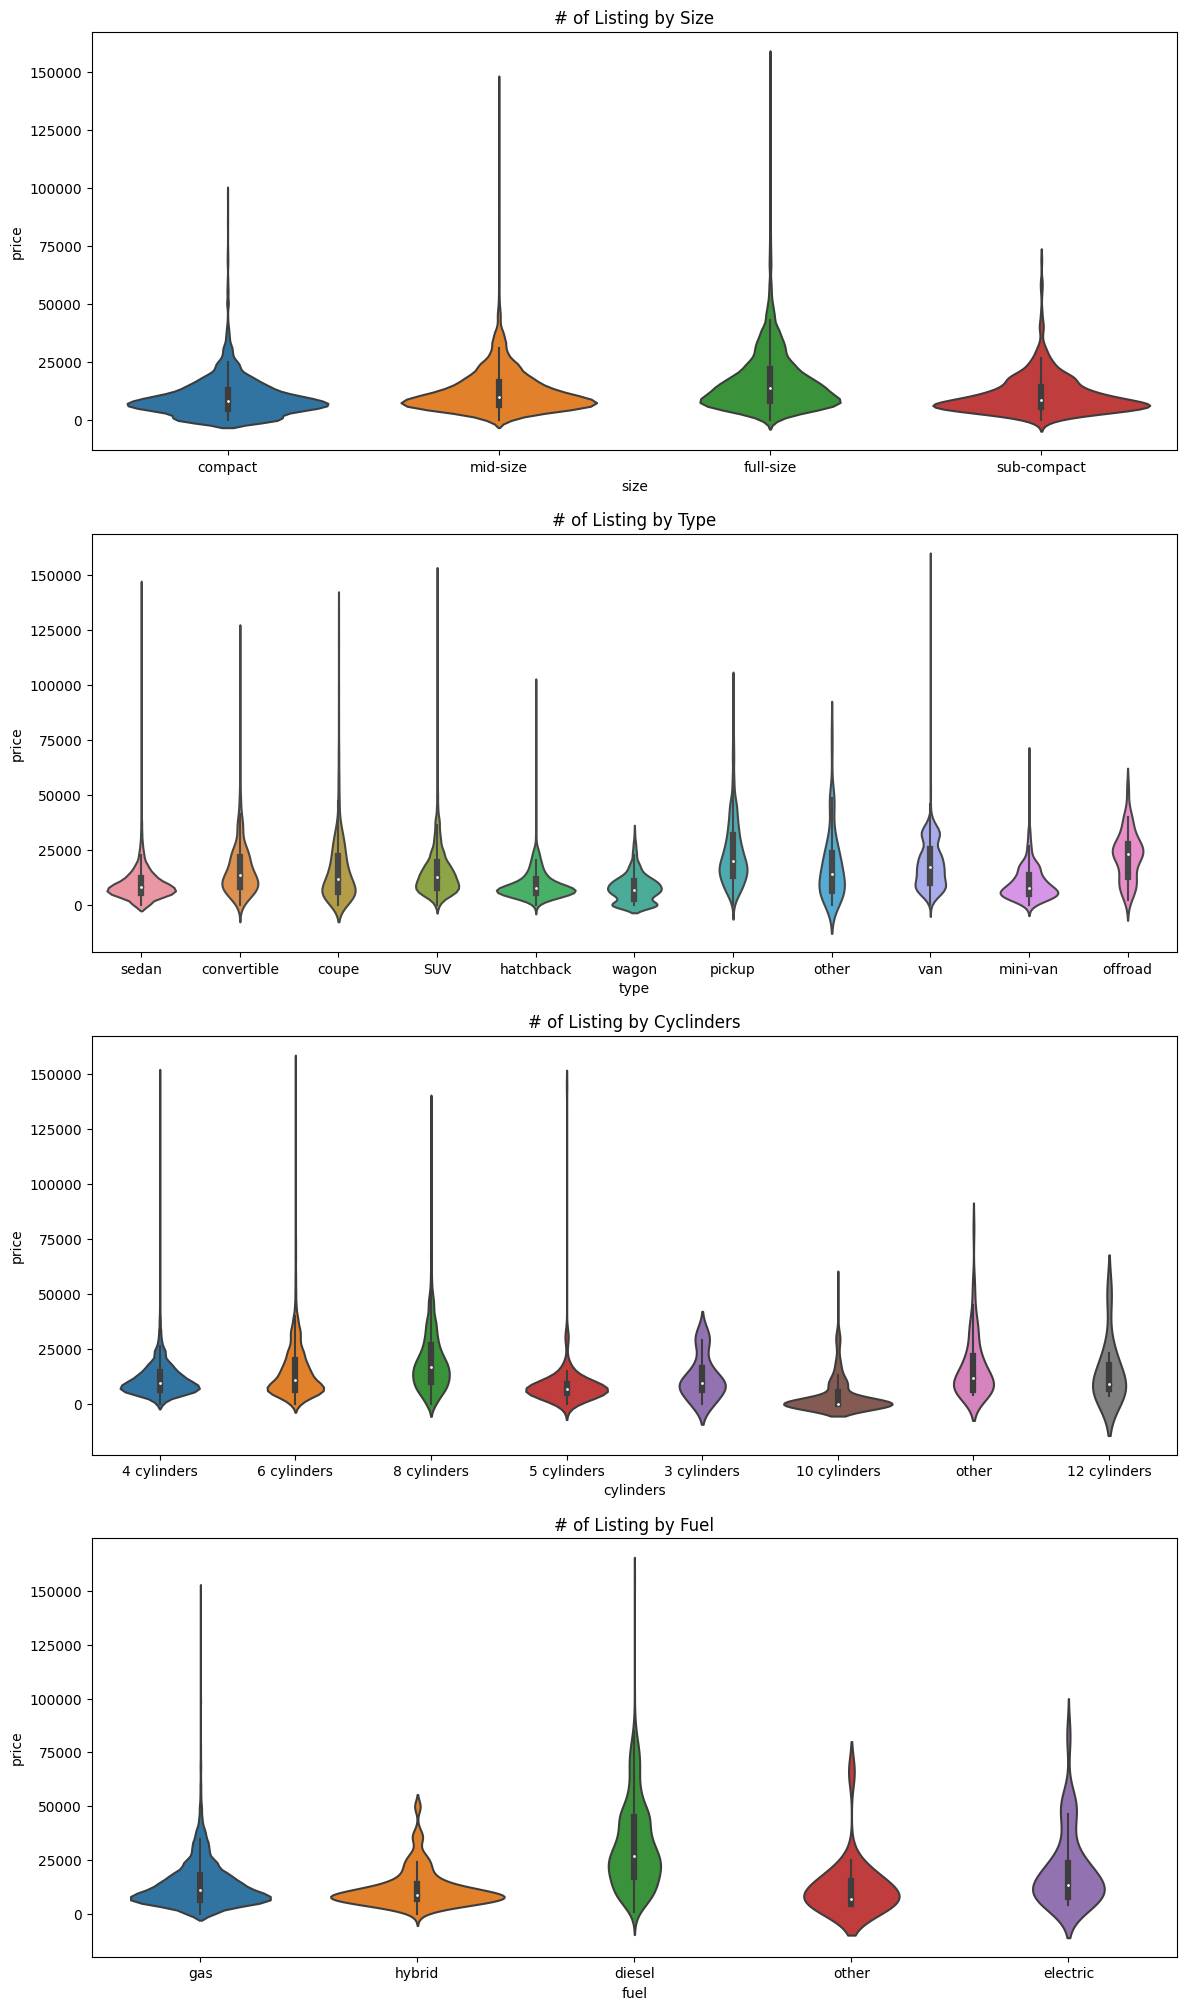

In [ ]:
fig,ax = plt.subplots(4, figsize=(14,25))
sns.violinplot(data=data2, x='size',y='price', ax=ax[0])
sns.violinplot(data=data2, x='type',y='price', ax=ax[1])
sns.violinplot(data=data2, x='cylinders',y='price', ax=ax[2])
sns.violinplot(data=data2, x='fuel',y='price', ax=ax[3])
ax[0].set_title('# of Listing by Size')
ax[1].set_title("# of Listing by Type")
ax[2].set_title("# of Listing by Cyclinders")
ax[3].set_title("# of Listing by Fuel")
#ax[0].set_xticklabels(fig1.get_xticklabels(), rotation=45, horizontalalignment='right')
#ax[1].set_xticklabels(fig1.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.show()

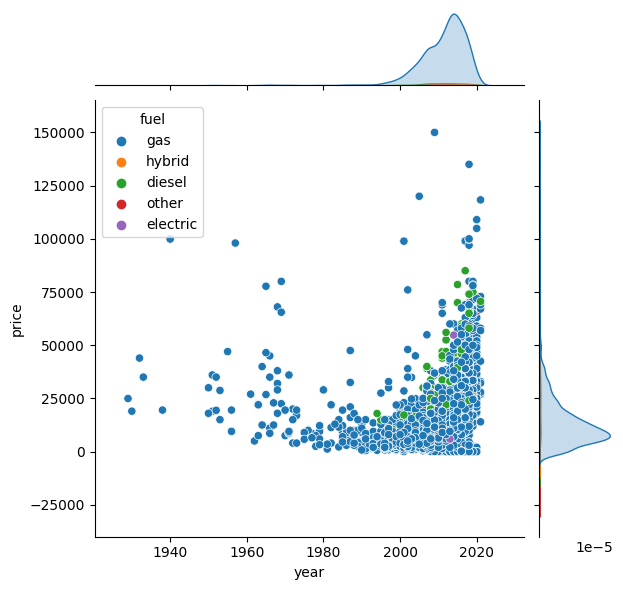

In [ ]:
sns.jointplot(data=data2, x='year',y='price', hue='fuel')
fig.show()

Text(0.5, 1.0, 'Used Car Inventory by Type')

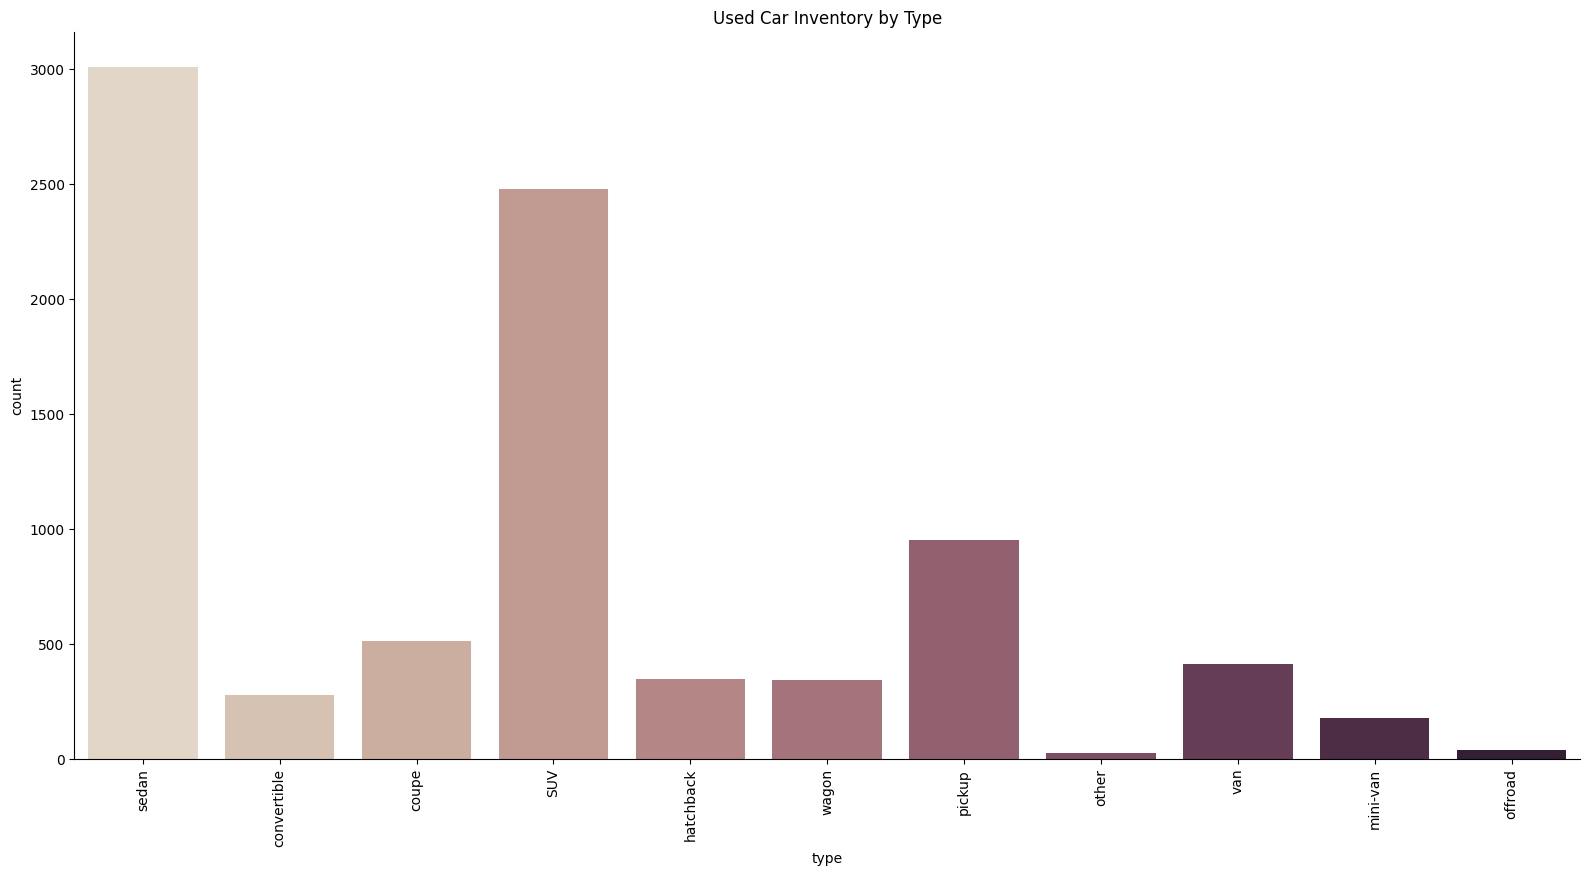

In [ ]:
#sns.histplot(data2, x='type', hue='size').set(title="# of Listing by Type")
#plt.xticks(rotation=90)
#plt.figure(figsize=(20, 10))
sns.catplot(x='type', kind="count", palette="ch:.25", height=8, aspect=2, data=data2);
plt.xticks(rotation=90);
plt.title('Used Car Inventory by Type')

Text(0.5, 1.0, 'Used Car Inventory by Fuel')

<Figure size 2000x1000 with 0 Axes>

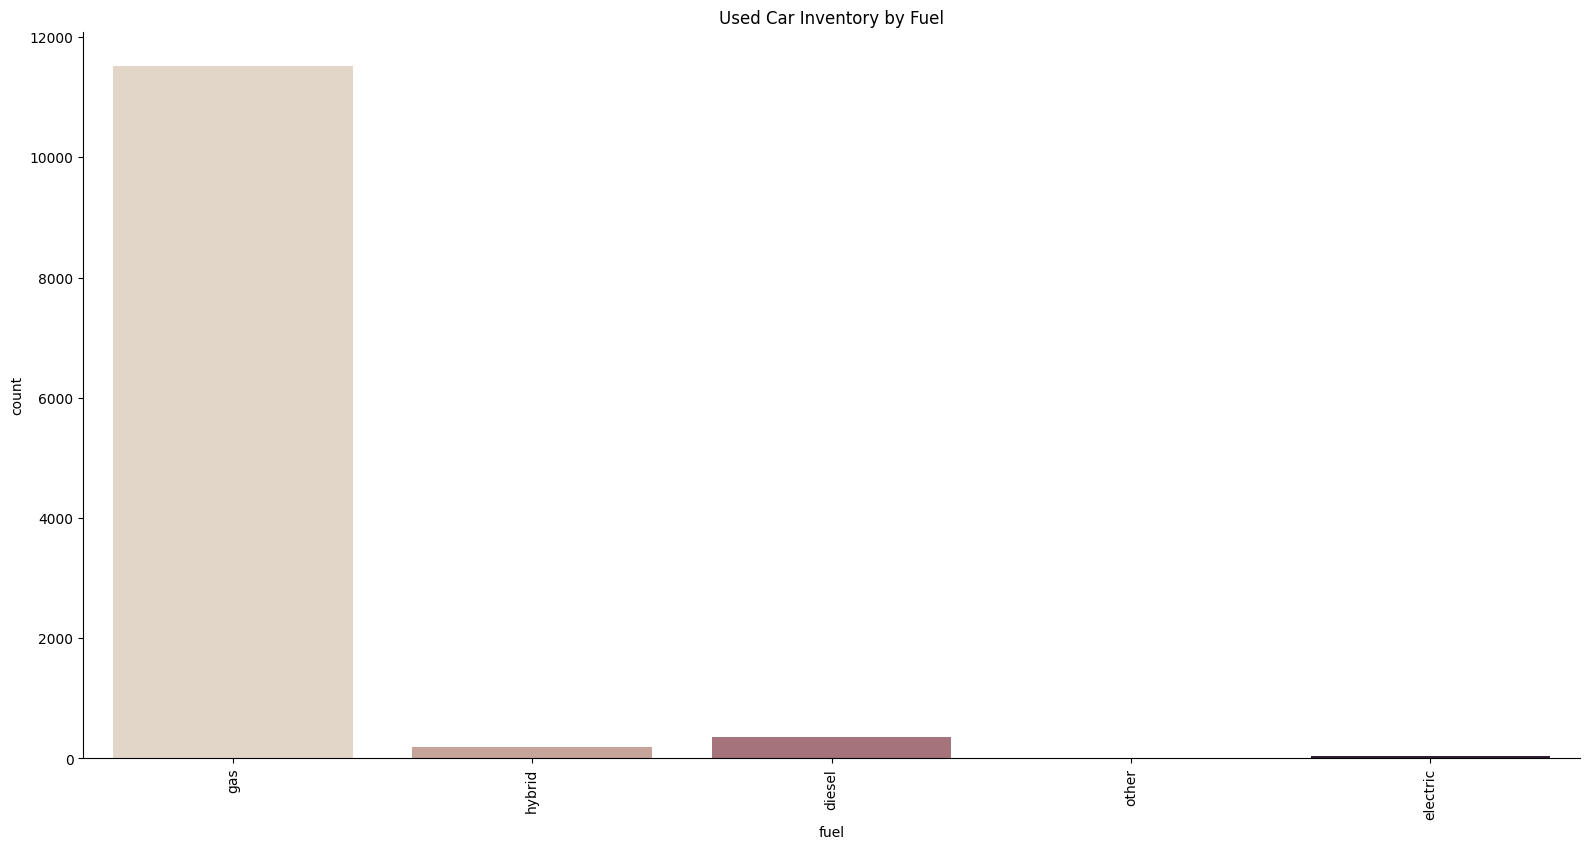

In [ ]:
plt.figure(figsize=(20, 10))
sns.catplot(x='fuel', kind="count", palette="ch:.25", height=8, aspect=2, data=data2);
plt.xticks(rotation=90);
plt.title('Used Car Inventory by Fuel Type')

Text(0.5, 1.0, 'Used Car Inventory by Manufacturer')

<Figure size 2000x1000 with 0 Axes>

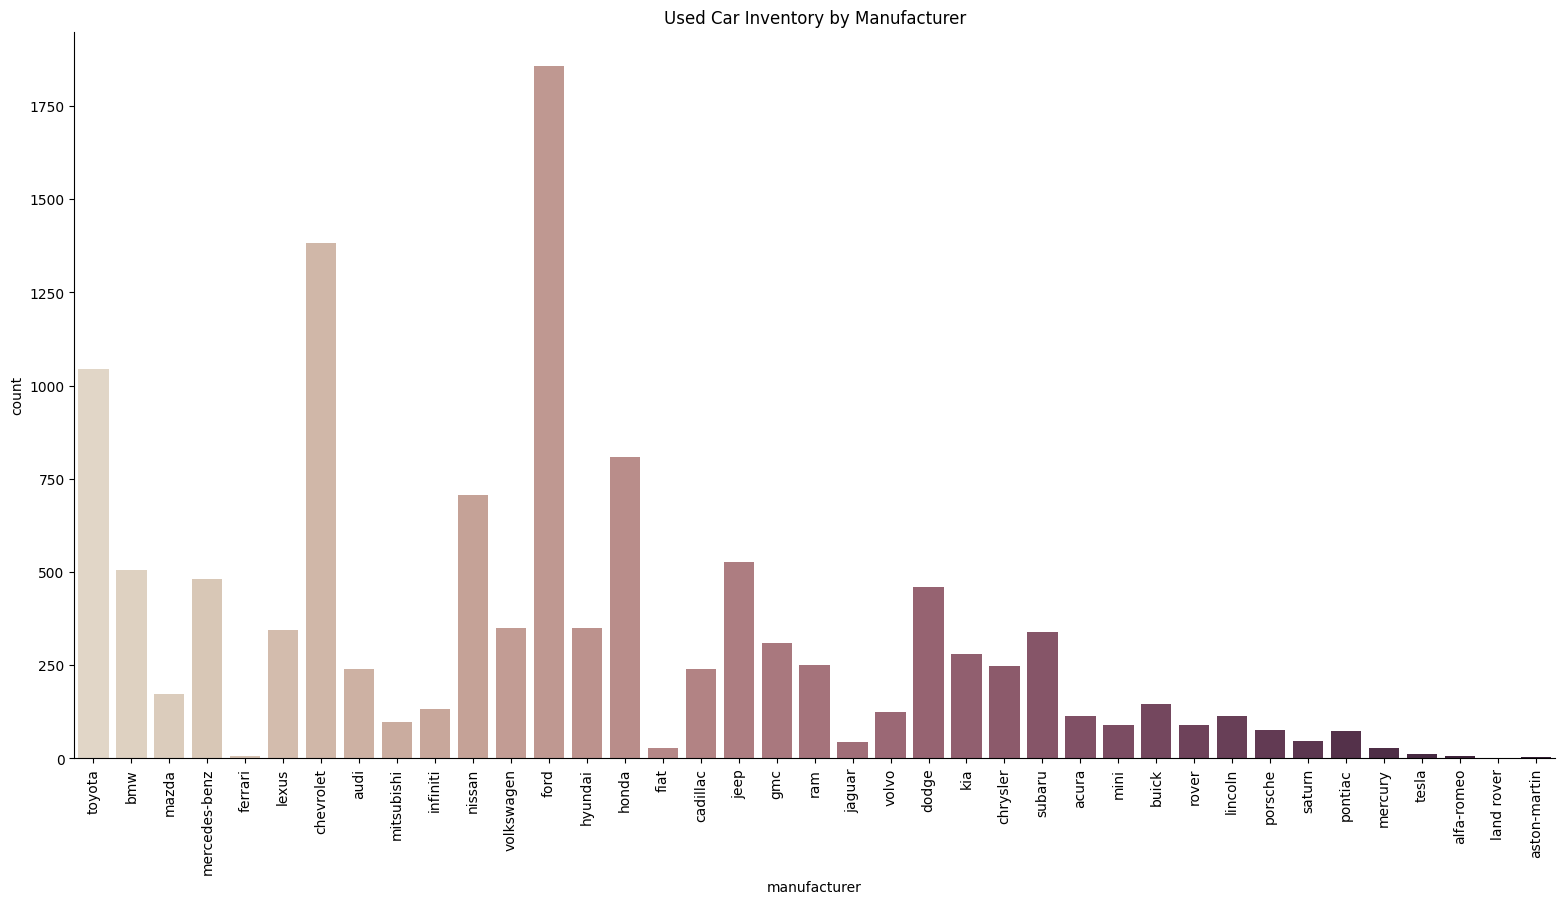

In [ ]:
plt.figure(figsize=(20, 10))
sns.catplot(x='manufacturer', kind="count", palette="ch:.25", height=8, aspect=2, data=data2);
plt.xticks(rotation=90);
plt.title('Used Car Inventory by Manufacturer')

Text(0.5, 1.0, 'Used Car Inventory by Size')

<Figure size 2000x1000 with 0 Axes>

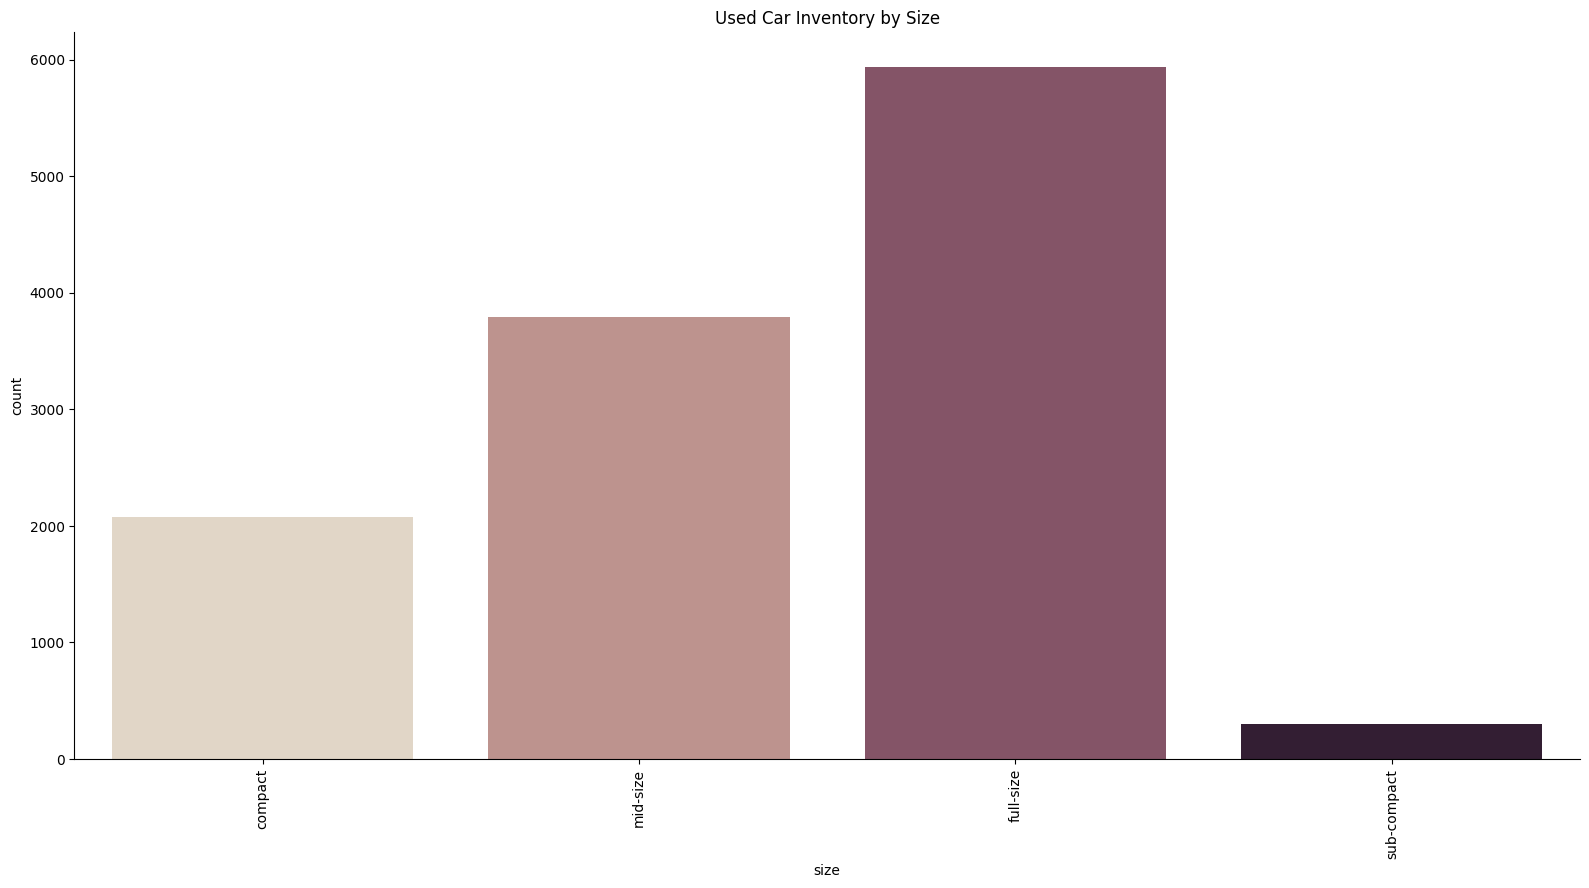

In [ ]:
plt.figure(figsize=(20, 10))
sns.catplot(x='size', kind="count", palette="ch:.25", height=8, aspect=2, data=data2);
plt.xticks(rotation=90);
plt.title('Used Car Inventory by Size')

Text(0.5, 1.0, 'Used Car Inventory by Year')

<Figure size 2000x1000 with 0 Axes>

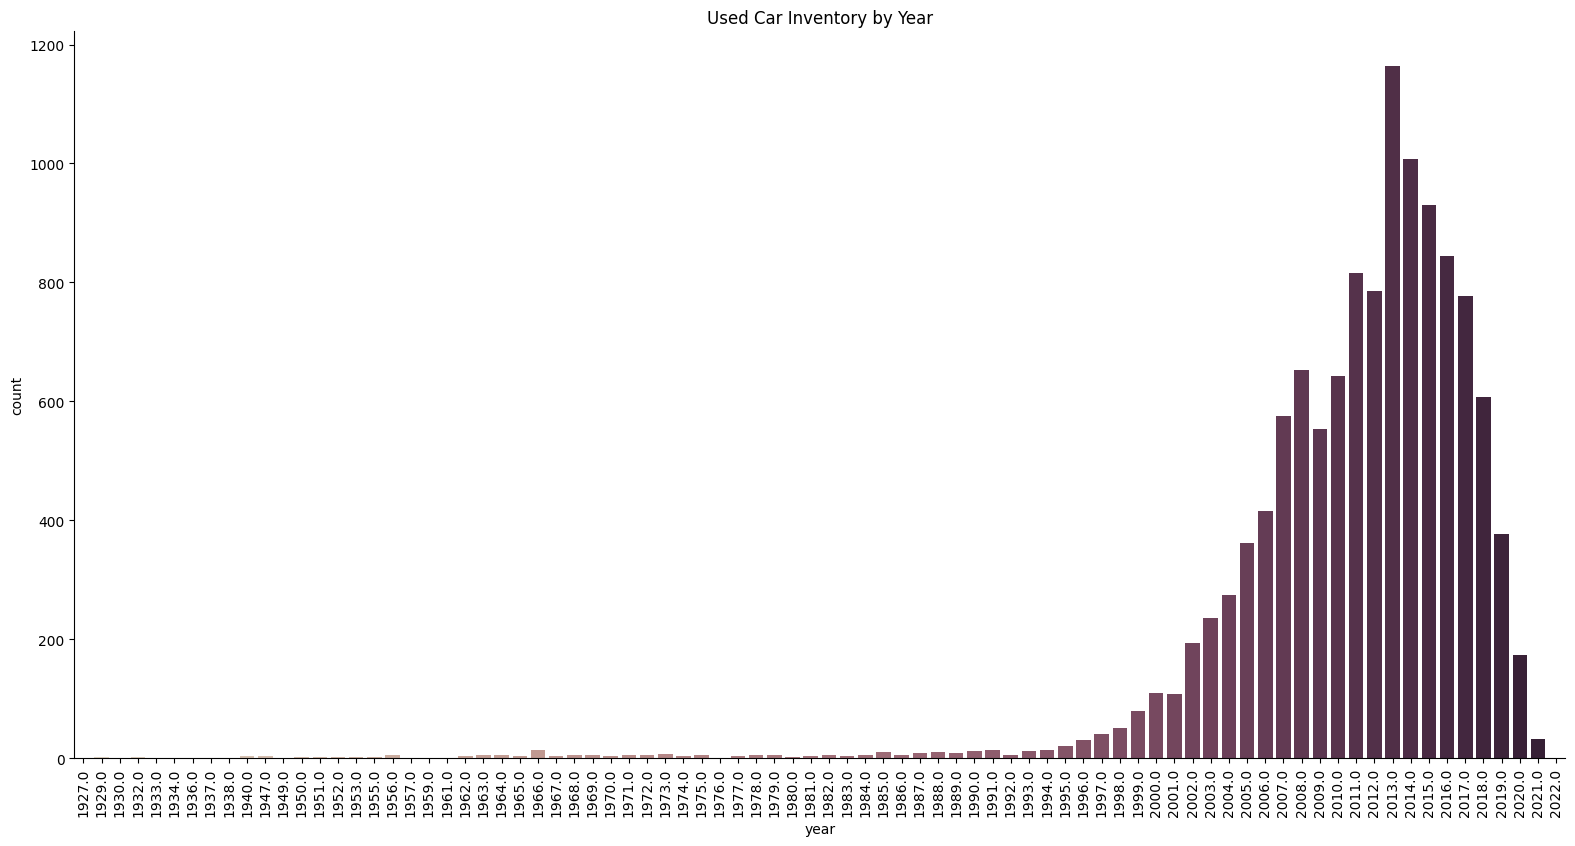

In [ ]:

plt.figure(figsize=(20, 10))
sns.catplot(x='year', kind="count", palette="ch:.25", height=8, aspect=2, data=data2);
plt.xticks(rotation=90);
plt.title('Used Car Inventory by Year')

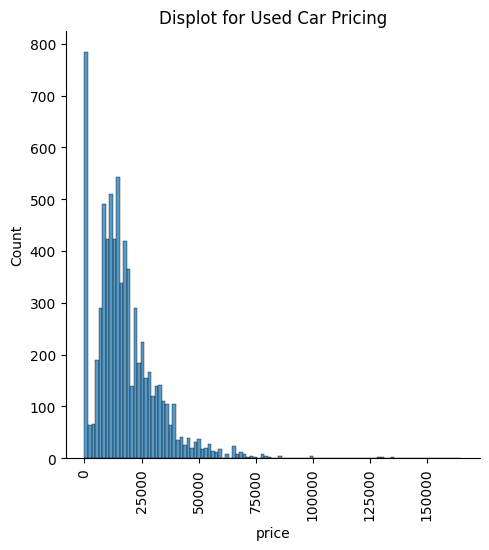

In [ ]:
sns.displot(data['price'])
plt.xticks(rotation=90);
plt.title("Displot for Used Car Pricing")
plt.show()

The following plot is the residual plot for the predicted values. Since the result is mostly randomly scattered around zero line. This is a good regression model. 

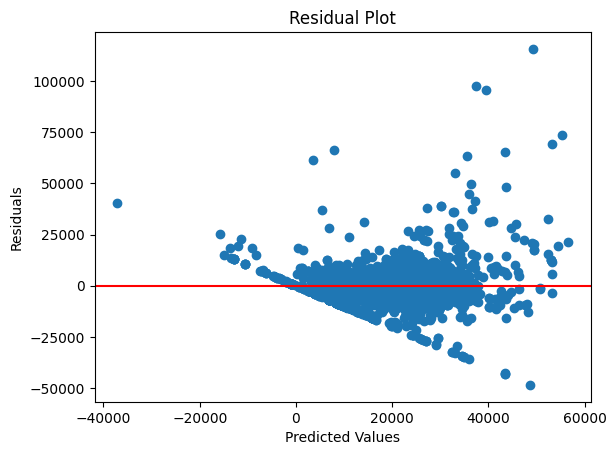

In [ ]:
residuals = y_test - test_preds
plt.scatter(test_preds, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.show()

In [ ]:
data2.loc[(data2.cylinders=='4 cylinders') & (data2.manufacturer == 'ford'), 'cylinders']='8 cylinders'

In [ ]:
data2.drop(data2[(data2.cylinders=='4 cylinders') & (data2.manufacturer == 'ford')& (data2.price  >100000)].index)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
346,7315259946,birmingham,98900,2001.0,ferrari,360 modena,good,8 cylinders,gas,20187.0,clean,automatic,ZFFYT53A110125703,rwd,mid-size,convertible,red,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426777,7303328804,wyoming,31995,2020.0,ram,promaster,good,6 cylinders,gas,18701.0,clean,automatic,3C6TRVAG6LE106273,fwd,full-size,van,white,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy


In [ ]:
data2.drop(data2[(data2.cylinders=='4 cylinders') & (data2.price > 100000) & (data2.manufacturer == 'ford')].index)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al
346,7315259946,birmingham,98900,2001.0,ferrari,360 modena,good,8 cylinders,gas,20187.0,clean,automatic,ZFFYT53A110125703,rwd,mid-size,convertible,red,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426777,7303328804,wyoming,31995,2020.0,ram,promaster,good,6 cylinders,gas,18701.0,clean,automatic,3C6TRVAG6LE106273,fwd,full-size,van,white,wy
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy
